In [ ]:
import pandas as pd
import numpy as np
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Collection

## TFRecord

In [ ]:
# Library import
import pandas as pd
import os
import re
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import VGG16
from functools import partial
from sklearn.model_selection import train_test_split

In [ ]:
# Constant Variables:
_auto_tune = tf.data.experimental.AUTOTUNE
_batch_size = 32

_image_width_original = 512
_image_height_original = 512
_image_size = [_image_width_original, _image_height_original]

_image_resize_width = 400
_image_resize_height = 400
_image_resize = [_image_resize_width, _image_resize_height]
print('Model input shape {} x {}.'.format(_image_resize_width, _image_resize_height))

_channels = 3
_n_class = 5
_n_repeat = 4
_img_norm = 255.0

_classes = [str(x) for x in range(_n_class)]
_major_label = 3
_classes_names = ['Cassava Bacterial Blight',
                  'Cassava Brown Streak Disease',
                  'Cassava Green Mottle',
                  'Cassava Mosaic Disease',
                  'Healthy']
_train_file = '/content/drive/MyDrive/sleepy_guys/cassava-leaf-disease-classification/train_tfrecords/'
_train_recs = os.listdir(_train_file)
_test_file = '/content/drive/MyDrive/sleepy_guys/cassava-leaf-disease-classification/test_tfrecords/'
_test_recs = os.listdir(_test_file)
_epochs = 300
_valid_size = 0.1
_train_df = pd.read_csv('/content/drive/MyDrive/sleepy_guys/cassava-leaf-disease-classification/train.csv', encoding='utf_8_sig', engine='python')
_file_label_map = dict(zip(_train_df.image_id.tolist(), _train_df.label.astype(int).tolist()))
_random_corp_size = [_image_resize_width, _image_resize_height, _channels]


Model input shape 400 x 400.


In [ ]:
# Decoding single image:
def decode_img(img,
               n_channels: int = _channels,
               img_size: list = None,
               img_norm : float = _img_norm):
    if img_size is None:
        img_size = _image_size
    img = tf.image.decode_jpeg(img, channels=n_channels)
    img = tf.reshape(img, [*img_size, n_channels])
    img = tf.cast(img, tf.float32) / img_norm
    return img


# Parsing the files
def parse_img(x,
              n_class: int = _n_class):
    feature_description = {'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
                           'target': tf.io.FixedLenFeature([], tf.int64, default_value=-1)}
    parsed_features = tf.io.parse_single_example(x, feature_description)
    img = decode_img(parsed_features['image'])
    label = tf.one_hot(parsed_features['target'], depth=n_class)
    return img, label


# Load data
def load_img(files: list):
    df = tf.data.TFRecordDataset(files)
    df = df.map(parse_img)
    return df


# Resize image
def resize_img(img,
               label,
               shape=None):
    if shape is None:
        shape = _image_resize
    return tf.image.resize(img, shape), label


# Sampling by randomly corp the picture with a fixed size:
def random_corp_sample_img(df,
                           corp_size=None,
                           n_repeat=_n_repeat):
    if corp_size is None:
        corp_size = _image_resize
    df_r = df.map(random_corp_img)
    for _ in range(n_repeat-1):
        df_r = df_r.concatenate(df.map(random_corp_img))
    return df_r


# Random corp:
def random_corp_img(img,
                    label,
                    size=None):
    if size is None:
        size = _random_corp_size
    img = tf.image.random_crop(img, size=size)
    return img, label


# Data Augmentation
def augment_img(img,
                label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, 0.5)
    img = tf.image.random_contrast(img, 0, 1)
    return img, label


In [ ]:
# Train-validation split
_train_fn, _valid_fn = \
    train_test_split(tf.io.gfile.glob(_train_file + 'ld_train*.tfrec'),
                     test_size=_valid_size,
                     random_state=5,
                     shuffle=True)
_test_fn = tf.io.gfile.glob(_test_file + 'ld_test*.tfrec')

In [ ]:
# Function for getting the training data set
def get_train_data(train_fn: list = _train_fn,
                   batch_size: int = _batch_size):
    df = load_img(train_fn)

    df_minor = df.filter(lambda x, y: tf.argmax(y) != _major_label)

    df_major = df.map(resize_img)
    df_minor = random_corp_sample_img(df_minor)
    df = df_major.concatenate(df_minor)

    df = df.map(augment_img)
    df = df.shuffle(buffer_size=2048)
    df = df.batch(batch_size).repeat()
    return df

def get_train_data2(train_fn: list = _train_fn,
                   batch_size: int = _batch_size):
    df = load_img(train_fn)

    # df_minor = df.filter(lambda x, y: tf.argmax(y) != _major_label)

    # df_major = df.map(resize_img)
    # df_minor = random_corp_sample_img(df_minor)
    # df = df_major.concatenate(df_minor)
    df = df.map(resize_img)
    df = df.map(augment_img)
    df = df.shuffle(buffer_size=2048)
    df = df.batch(batch_size).repeat()
    return df

# Function for getting the validation data set
def get_valid_data(valid_fn: list = _valid_fn,
                   batch_size: int = _batch_size):
    df = load_img(valid_fn)
    df = df.map(resize_img)
    df = df.batch(batch_size).cache()
    return df


# Function for getting the testing data set
def get_test_data(test_fn: list = _test_fn,
                  batch_size: int = _batch_size):
    df = load_img(test_fn)
    df = df.map(resize_img)
    df = df.batch(batch_size)
    return df


# Reporting the size of training, validation and testing data
def report_data_size(train_f=_train_fn,
                     valid_f=_valid_fn,
                     test_f=_test_fn):
    def count_file(x):
        return sum([int(re.compile(r"-([0-9]*)\.").search(i).group(1)) for i in x])
    n_train, n_valid, n_test = count_file(train_f), count_file(valid_f), count_file(test_f)
    print('Train Images: {} | Validation Images: {} | Test Images: {}'.format(n_train, n_valid, n_test))
    return n_train, n_valid, n_test


In [ ]:
# Check the size of the data
_n_train, _n_valid, _n_test = report_data_size()

Train Images: 18721 | Validation Images: 2676 | Test Images: 1


In [ ]:
# Fetching training, validation and testing data
train_data = get_train_data2()
valid_data = get_valid_data()
test_data = get_test_data()

In [ ]:
print("Train Data Size {} | Validation Data Size {} | Test Data Size {}".format(train_data._flat_shapes, valid_data._flat_shapes, test_data._flat_shapes))

Train Data Size [TensorShape([None, 400, 400, 3]), TensorShape([None, 5])] | Validation Data Size [TensorShape([None, 400, 400, 3]), TensorShape([None, 5])] | Test Data Size [TensorShape([None, 400, 400, 3]), TensorShape([None, 5])]


## Model building and training

In [ ]:
EPOCHS = 100
BATCH_SIZE = 64
LR = 0.001

In [ ]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Input

base = ResNet152V2(include_top=False, weights = 'imagenet', input_shape = (400,400,3))

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, AveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from tensorflow.keras import regularizers

#Construct structure after ResNet
head = base.output
head = AveragePooling2D(pool_size=(2,2))(head)
head = BatchNormalization()(head)
head = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(head)
head = MaxPool2D(pool_size=(2, 2))(head)
head = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(head)
head = MaxPool2D(pool_size=(2, 2))(head)
head = Flatten()(head)
head = Dense(256, activation='relu', kernel_initializer="he_normal")(head)
head = Dense(128, activation='relu')(head)
#head = Dropout(rate=0.2)(head)
head = Dense(5, activation='softmax')(head)

# Combine the model
model = Model(inputs=base.input, outputs=head)

# Freeze base layers
base.trainable = False

# Compile the model
model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate = LR), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainAug = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True
)

In [ ]:
# Add Earlystopping to monitor validation loss
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5)

In [ ]:
# Train model
H = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=valid_data,
    steps_per_epoch=_n_train // BATCH_SIZE,
    validation_steps=_n_valid // BATCH_SIZE
)

Epoch 1/100
292/292 [==============================] - 168s 499ms/step - loss: 1.0915 - accuracy: 0.6229 - val_loss: 0.7889 - val_accuracy: 0.7020
Epoch 2/100
292/292 [==============================] - 130s 444ms/step - loss: 0.8127 - accuracy: 0.6927 - val_loss: 0.7403 - val_accuracy: 0.7264
Epoch 3/100
292/292 [==============================] - 155s 532ms/step - loss: 0.7917 - accuracy: 0.7135 - val_loss: 0.6530 - val_accuracy: 0.7660
Epoch 4/100
292/292 [==============================] - 127s 433ms/step - loss: 0.7503 - accuracy: 0.7250 - val_loss: 0.6327 - val_accuracy: 0.7675
Epoch 5/100
292/292 [==============================] - 153s 526ms/step - loss: 0.7570 - accuracy: 0.7290 - val_loss: 0.6303 - val_accuracy: 0.7691
Epoch 6/100
292/292 [==============================] - 126s 432ms/step - loss: 0.7077 - accuracy: 0.7485 - val_loss: 0.6003 - val_accuracy: 0.7828
Epoch 7/100
292/292 [==============================] - 156s 535ms/step - loss: 0.7009 - accuracy: 0.7441 - val_loss: 0

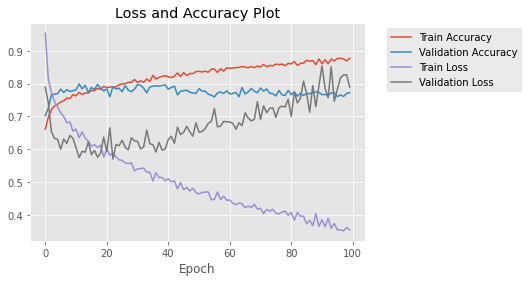

In [ ]:
#Plot

import matplotlib.pyplot as plt

N = len(H.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="Validation Accuracy")
plt.plot(np.arange(0, N), H.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("performance_plot.png")